In [5]:
import numpy as np
import matplotlib.pyplot as plt
from pytransform3d import rotations as pr
from pytransform3d import transformations as pt
from pytransform3d.transform_manager import TransformManager




In [6]:
rng = np.random.default_rng(0)

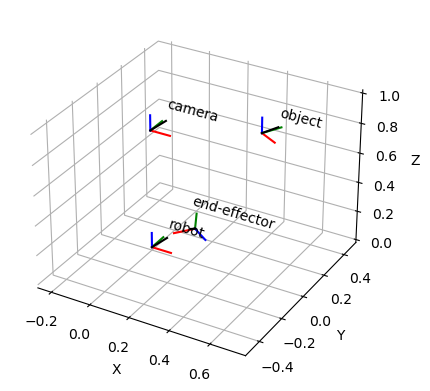

In [7]:


ee2robot = pt.transform_from_pq(
    np.hstack((np.array([0.4, -0.3, 0.5]),
               pr.random_quaternion(rng))))

cam2robot = pt.transform_from_pq(
    np.hstack((np.array([0.0, 0.0, 0.8]), pr.q_id)))

object2cam = pt.transform_from(
    pr.active_matrix_from_intrinsic_euler_xyz(np.array([0.0, 0.0, -0.5])),
    np.array([0.5, 0.1, 0.1]))

tm = TransformManager()
tm.add_transform("end-effector", "robot", ee2robot)
tm.add_transform("camera", "robot", cam2robot)
tm.add_transform("object", "camera", object2cam)

ee2object = tm.get_transform("end-effector", "object")

ax = tm.plot_frames_in("robot", s=0.1)
ax.set_xlim((-0.25, 0.75))
ax.set_ylim((-0.5, 0.5))
ax.set_zlim((0.0, 1.0))
plt.show()

In [24]:
"""
=============================
Dual Quaternion Interpolation
=============================

This example shows interpolated trajectories between two random poses.
The red line corresponds to linear interpolation with exponential coordinates,
the green line corresponds to linear interpolation with dual quaternions,
and the blue line corresponds to screw linear interpolation (ScLERP) with
dual quaternions. The true screw motion from pose 1 to pose 2 is shown by
a thick, transparent black line in the background of the ScLERP interpolation.
"""
import numpy as np
import matplotlib.pyplot as plt
import pytransform3d.transformations as pt
import pytransform3d.trajectories as ptr
import pytransform3d.plot_utils as ppu

In [25]:
rng = np.random.default_rng(15)

In [26]:
pose1 = pt.random_transform(rng)
pose2 = pt.random_transform(rng)

dq1 = pt.dual_quaternion_from_transform(pose1)
dq2 = -pt.dual_quaternion_from_transform(pose2)

Stheta1 = pt.exponential_coordinates_from_transform(pose1)
Stheta2 = pt.exponential_coordinates_from_transform(pose2)

pq1 = pt.pq_from_transform(pose1)
pq2 = pt.pq_from_transform(pose2)

In [27]:
n_steps = 100

In [28]:
# Ground truth screw motion: linear interpolation of rotation about and
# translation along the screw axis
pose12pose2 = pt.concat(pose2, pt.invert_transform(pose1))
screw_axis, theta = pt.screw_axis_from_exponential_coordinates(
    pt.exponential_coordinates_from_transform(pose12pose2))
offsets = np.array(
    [pt.transform_from_exponential_coordinates(screw_axis * t * theta)
     for t in np.linspace(0, 1, n_steps)])
interpolated_poses = np.array([
    pt.concat(offset, pose1) for offset in offsets])

In [29]:
# Linear interpolation of dual quaternions
interpolated_dqs = (np.linspace(1, 0, n_steps)[:, np.newaxis] * dq1 +
                    np.linspace(0, 1, n_steps)[:, np.newaxis] * dq2)
# renormalization (not required here because it will be done with conversion)
interpolated_dqs /= np.linalg.norm(
    interpolated_dqs[:, :4], axis=1)[:, np.newaxis]
interpolated_poses_from_dqs = np.array([
    pt.transform_from_dual_quaternion(dq) for dq in interpolated_dqs])

In [30]:
# Screw linear interpolation of dual quaternions (ScLERP)
sclerp_interpolated_dqs = np.vstack([
    pt.dual_quaternion_sclerp(dq1, dq2, t)
    for t in np.linspace(0, 1, n_steps)])
sclerp_interpolated_poses_from_dqs = ptr.transforms_from_dual_quaternions(
    sclerp_interpolated_dqs)

In [31]:
# Linear interpolation of exponential coordinates
interpolated_ecs = (np.linspace(1, 0, n_steps)[:, np.newaxis] * Stheta1 +
                    np.linspace(0, 1, n_steps)[:, np.newaxis] * Stheta2)
interpolates_poses_from_ecs = ptr.transforms_from_exponential_coordinates(
    interpolated_ecs)

In [32]:
# Linear interpolation of position + spherical linear interpolation (SLERP) of
# quaternion
interpolated_pqs = np.vstack([
    pt.pq_slerp(pq1, pq2, t) for t in np.linspace(0, 1, n_steps)])
interpolated_poses_from_pqs = ptr.transforms_from_pqs(interpolated_pqs)

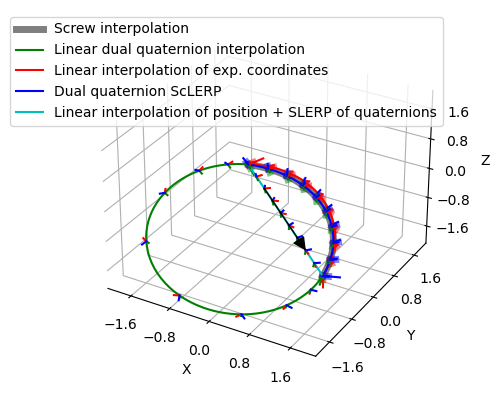

In [33]:
ax = pt.plot_transform(A2B=pose1, s=0.3, ax_s=2)
pt.plot_transform(A2B=pose2, s=0.3, ax=ax)

traj = ppu.Trajectory(
    interpolated_poses, s=0.1, c="k", lw=5, alpha=0.5, show_direction=True)
traj.add_trajectory(ax)

traj_from_dqs = ppu.Trajectory(
    interpolated_poses_from_dqs, s=0.1, c="g", show_direction=False)
traj_from_dqs.add_trajectory(ax)

traj_from_ecs = ppu.Trajectory(
    interpolates_poses_from_ecs, s=0.1, c="r", show_direction=False)
traj_from_ecs.add_trajectory(ax)

traj_from_dqs_sclerp = ppu.Trajectory(
    sclerp_interpolated_poses_from_dqs, s=0.1, c="b", show_direction=False)
traj_from_dqs_sclerp.add_trajectory(ax)

traj_from_pq_slerp = ppu.Trajectory(
    interpolated_poses_from_pqs, s=0.1, c="c", show_direction=False)
traj_from_pq_slerp.add_trajectory(ax)

plt.legend(
    [traj.trajectory, 
     traj_from_dqs.trajectory, 
     traj_from_ecs.trajectory,
     traj_from_dqs_sclerp.trajectory, 
     traj_from_pq_slerp.trajectory],
    ["Screw interpolation", 
     "Linear dual quaternion interpolation",
     "Linear interpolation of exp. coordinates", 
     "Dual quaternion ScLERP",
     "Linear interpolation of position + SLERP of quaternions"],
    loc="best")
plt.show()

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pytransform3d.rotations as pyrot
import pytransform3d.transformations as pytr
from pytransform3d.plot_utils import plot_vector

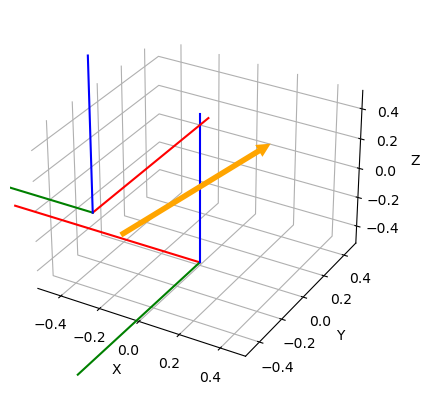

In [37]:
p = np.array([0.0, 0.0, -0.5])
a = np.array([0.0, 0.0, 1.0, np.pi])
B2A = pytr.transform_from(pyrot.matrix_from_axis_angle(a), p)

p = np.array([0.3, 0.4, 0.5])
a = np.array([0.0, 0.0, 1.0, -np.pi / 2.0])
C2B = pytr.transform_from(pyrot.matrix_from_axis_angle(a), p)

C2A = pytr.concat(C2B, B2A)
p = pytr.transform(C2A, np.ones(4))

ax = pytr.plot_transform(A2B=B2A)
pytr.plot_transform(ax, A2B=C2A)
ax.scatter(p[0], p[1], p[2])

plot_vector(
    # A vector is defined by start, direction, and s (scaling)
    start=np.array([-0.3, -0.2, -0.3]),
    direction=np.array([1.0, 1.0, 1.0]),
    s=0.5,
    ax_s=0.5,  # Scaling of 3D axes
    lw=0,  # Remove line around arrow
    color="orange"
)

plt.show()


A dual quaternion consists of a real quaternion and a dual quaternion:

$$\boldsymbol{p} + \epsilon \boldsymbol{q} = p_w + p_x i + p_y j + p_z k + \epsilon (q_w + q_x i + q_y j + q_z k)$$

where $\epsilon^2 = 0$. We use unit dual quaternions to represent transformations. In this case, the real quaternion is a unit quaternion and the dual quaternion is orthogonal to the real quaternion. The real quaternion is used to represent the rotation and the dual quaternion contains information about the rotation and translation.

Dual quaternions support similar operations as transformation matrices, they can be renormalized efficiently, and interpolation between two dual quaternions is possible.

While it is possible to carry out all of the analysis in this chapter using an arbitrary frame attached to each link, it is helpful to be systematic in the choice of these frames. A commonly used convention for selecting frames of reference in robotic applications is the Denavit-Hartenberg, or D-H convention. In this convention, each homogeneous transformation Ai is represented as a product of four basic transformations

In [38]:
import numpy as np

def R_z(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta), 0, 0], 
        [np.sin(theta),  np.cos(theta), 0, 0], 
        [0,              0,             1, 0],     
        [0,              0,             0, 1]
    ])

def T_z(d):
    return np.array([
        [1, 0, 0, 0], 
        [0, 1, 0, 0], 
        [0, 0, 1, d],     
        [0, 0, 0, 1]
    ])

def T_x(a):
    return np.array([
        [1, 0, 0, a], 
        [0, 1, 0, 0], 
        [0, 0, 1, 0],     
        [0, 0, 0, 1]
    ])

def R_x(alpha):
    return np.array([
        [1, 0,              0,             0],
        [0, np.cos(alpha), -np.sin(alpha), 0], 
        [0, np.sin(alpha),  np.cos(alpha), 0], 
        [0,              0,             0, 1]
    ])


# Print the array
print(R_z(1))

[[ 0.54030231 -0.84147098  0.          0.        ]
 [ 0.84147098  0.54030231  0.          0.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]


In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pytransform3d.transformations as pt
import pytransform3d.trajectories as ptr
import pytransform3d.plot_utils as ppu


rng = np.random.default_rng(25)
pose1 = pt.random_transform(rng)
pose2 = pt.random_transform(rng)
dq1 = pt.dual_quaternion_from_transform(pose1)
dq2 = -pt.dual_quaternion_from_transform(pose2)

Stheta1 = pt.exponential_coordinates_from_transform(pose1)
Stheta2 = pt.exponential_coordinates_from_transform(pose2)
pq1 = pt.pq_from_transform(pose1)
pq2 = pt.pq_from_transform(pose2)

n_steps = 100

# Ground truth screw motion: linear interpolation of rotation about and
# translation along the screw axis
pose12pose2 = pt.concat(pose2, pt.invert_transform(pose1))
screw_axis, theta = pt.screw_axis_from_exponential_coordinates(
    pt.exponential_coordinates_from_transform(pose12pose2))
offsets = np.array(
    [pt.transform_from_exponential_coordinates(screw_axis * t * theta)
     for t in np.linspace(0, 1, n_steps)])
interpolated_poses = np.array([
    pt.concat(offset, pose1) for offset in offsets])

# Linear interpolation of dual quaternions
interpolated_dqs = (np.linspace(1, 0, n_steps)[:, np.newaxis] * dq1 +
                    np.linspace(0, 1, n_steps)[:, np.newaxis] * dq2)
# renormalization (not required here because it will be done with conversion)
interpolated_dqs /= np.linalg.norm(
    interpolated_dqs[:, :4], axis=1)[:, np.newaxis]
interpolated_poses_from_dqs = np.array([
    pt.transform_from_dual_quaternion(dq) for dq in interpolated_dqs])

# Screw linear interpolation of dual quaternions (ScLERP)
sclerp_interpolated_dqs = np.vstack([
    pt.dual_quaternion_sclerp(dq1, dq2, t)
    for t in np.linspace(0, 1, n_steps)])
sclerp_interpolated_poses_from_dqs = ptr.transforms_from_dual_quaternions(
    sclerp_interpolated_dqs)

# Linear interpolation of exponential coordinates
interpolated_ecs = (np.linspace(1, 0, n_steps)[:, np.newaxis] * Stheta1 +
                    np.linspace(0, 1, n_steps)[:, np.newaxis] * Stheta2)
interpolates_poses_from_ecs = ptr.transforms_from_exponential_coordinates(
    interpolated_ecs)

# Linear interpolation of position + spherical linear interpolation (SLERP) of
# quaternion
interpolated_pqs = np.vstack([
    pt.pq_slerp(pq1, pq2, t) for t in np.linspace(0, 1, n_steps)])
interpolated_poses_from_pqs = ptr.transforms_from_pqs(interpolated_pqs)

ax = pt.plot_transform(A2B=pose1, s=0.3, ax_s=2)
pt.plot_transform(A2B=pose2, s=0.3, ax=ax)
traj = ppu.Trajectory(
    interpolated_poses, s=0.1, c="k", lw=5, alpha=0.5, show_direction=True)
traj.add_trajectory(ax)
traj_from_dqs = ppu.Trajectory(
    interpolated_poses_from_dqs, s=0.1, c="g", show_direction=False)
traj_from_dqs.add_trajectory(ax)
traj_from_ecs = ppu.Trajectory(
    interpolates_poses_from_ecs, s=0.1, c="r", show_direction=False)
traj_from_ecs.add_trajectory(ax)

traj_from_dqs_sclerp = ppu.Trajectory(
    sclerp_interpolated_poses_from_dqs, s=0.1, c="b", show_direction=False)
traj_from_dqs_sclerp.add_trajectory(ax)
traj_from_pq_slerp = ppu.Trajectory(
    interpolated_poses_from_pqs, s=0.1, c="c", show_direction=False)
traj_from_pq_slerp.add_trajectory(ax)
plt.legend(
    [traj.trajectory, traj_from_dqs.trajectory, traj_from_ecs.trajectory,
     traj_from_dqs_sclerp.trajectory, traj_from_pq_slerp.trajectory],
    ["Screw interpolation", "Linear dual quaternion interpolation",
     "Linear interpolation of exp. coordinates", "Dual quaternion ScLERP",
     "Linear interpolation of position + SLERP of quaternions"],
    loc="best")
plt.show()

ModuleNotFoundError: No module named 'pytransform3d.quaternions'